# Fase 1: Importar las dependencias

In [2]:
import numpy as np
import math
import re
import pandas as pd
#from bs4 import BeautifulSoup
import random

from google.colab import drive
import gdown

In [2]:
!pip install bert-for-tf2 #BERT para TF esta es una version reducida
!pip install sentencepiece #para trabajar con Tokens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30509 sha256=c2ac60765eb77f9a841ff8d2cf9e9b7315313446995da59c13466742e74407a0
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19455 sha256=e9236b173ab5efe5e7ac700aff6fbd6d1ca7b9c5ff17a2bc1390125a0a66a045
  Stored in directory: /root/.cache/pip/wheels/97/a8/d0/f7419404174976a2686bb98b5c30df01cc71445415f32db9e6
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7892 sha256=695ff6411e0f3c176dc3b4424b3e25b3ca1c5df5b7c6906a783cbb2f58752083
  Stored in directory: /root/.cache/pip/wheels/69/c8/b3/92666cff9fb312bc3473eaa6b396695b89a7b3e31e908768

In [3]:
try:
    %tensorflow_version 2.x #esto es para asegurarse que usamos la version 2
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub #Es una biblioteca modulos subidos por usuarios y desarrolladores

from tensorflow.keras import layers# para generar las capas
import bert #modulo BERT

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Fase 2: Pre Procesado de Datos

## Carga de los ficheros

Los datos son extraidos de http://help.sentiment140.com/for-students .

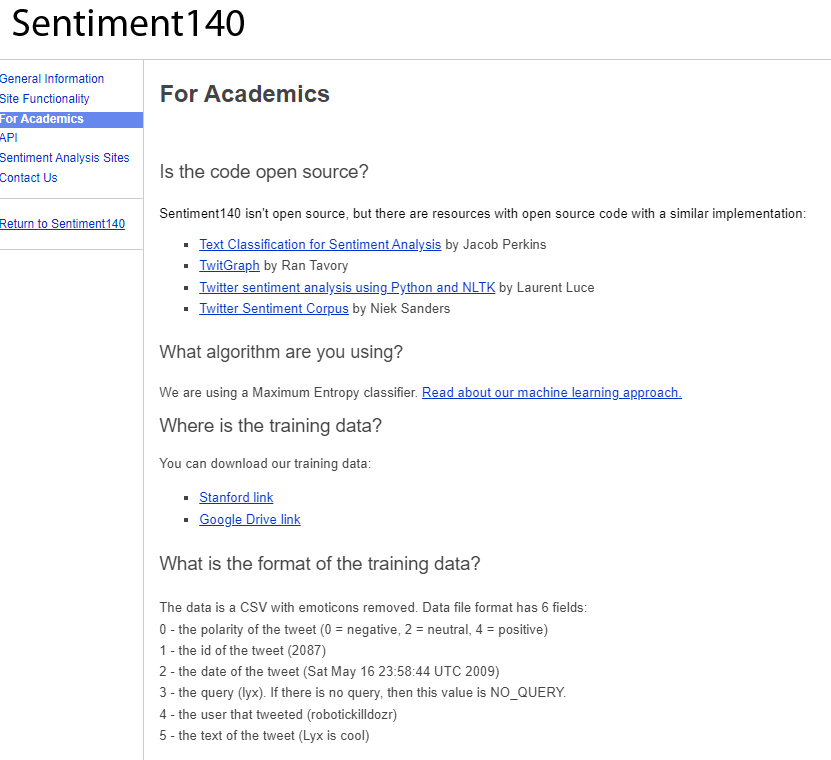


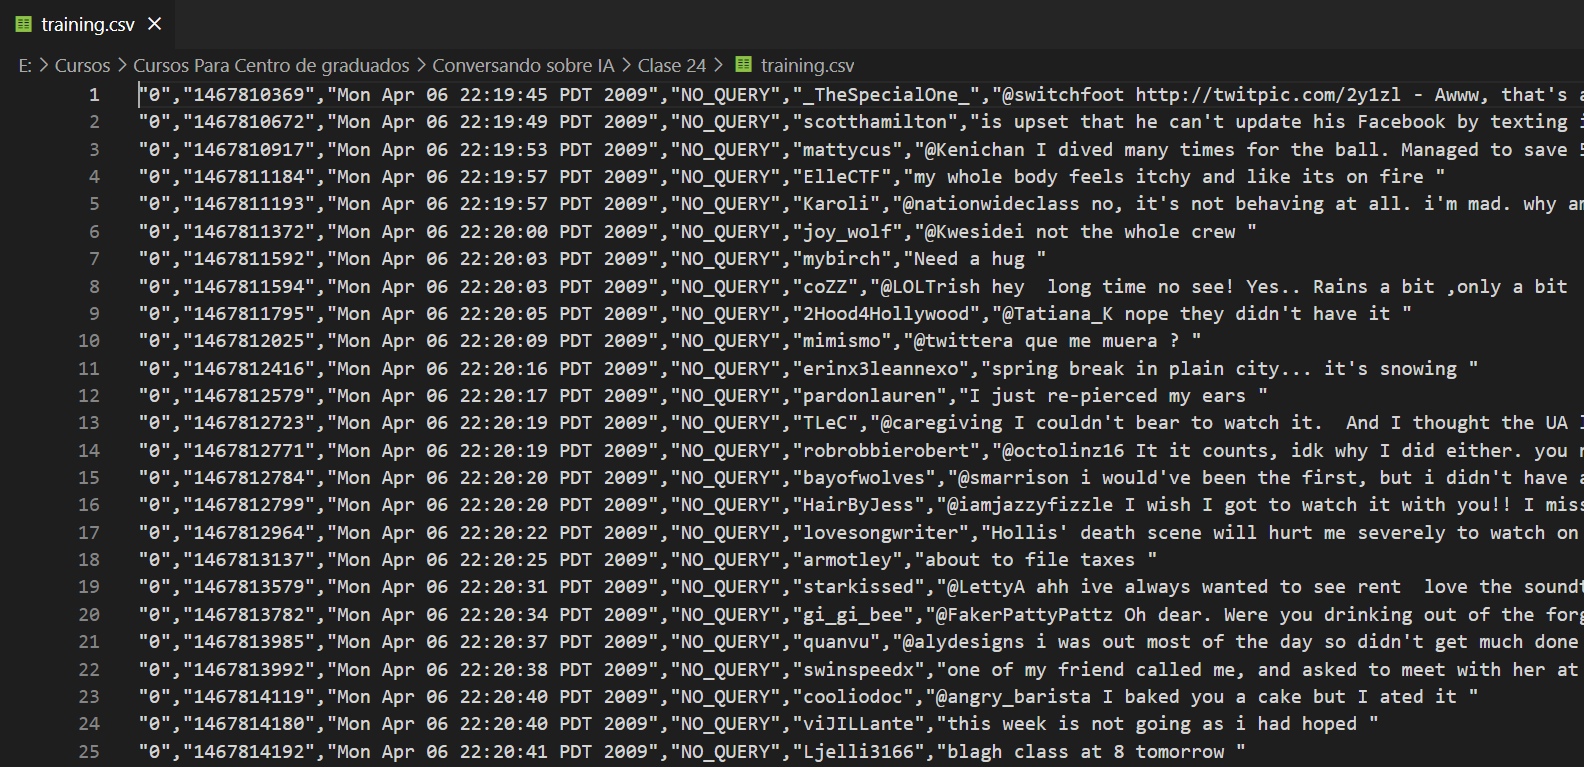

In [4]:

url = 'https://drive.google.com/uc?id=1-rdiEj0Dy-j5M875bphbdF_qpSYAfT0t'
output = 'data.csv'
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1-rdiEj0Dy-j5M875bphbdF_qpSYAfT0t
To: /content/data.csv
100%|██████████| 239M/239M [00:01<00:00, 174MB/s]


'data.csv'

In [5]:
cols = ["sentiment", "id", "date", "query", "user", "text"]#agregamos cabecera
data = pd.read_csv(
    "/content/data.csv",
    header=None,  #porque no viene con cabecera
    names=cols, #indicamos cual es la cabecera que queremos
    engine="python",
    encoding="latin1"
)

In [6]:
print(data) #para ver como son los datos

         sentiment          id                          date     query  \
0                0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1                0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2                0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3                0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4                0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...            ...         ...                           ...       ...   
1599995          4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996          4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997          4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998          4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999          4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                               text  
0        _TheSpecialOne_  @switch

In [9]:
data.head()#son los primeros 5

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
data.tail()#son los ultimos 5

,sentiment,id,date,query,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [11]:
data.drop(["id", "date", "query", "user"], #quitamos las columnas que no vamos a usar
          axis=1, #indica que queremos eliminar las columnas
          inplace=True)

In [15]:
data.head(10)#vemos los 10 primeros

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


## Pre Procesado

### Limpieza

In [13]:
# def clean_tweet(tweet): #definimos una funcion para hacer limpieza
#     tweet = BeautifulSoup(tweet, "lxml").get_text()
#     # Remover los @ (menciones)
#     tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
#     # Remover las URL links http o https
#     tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
#     # Conservar solo letras (cabiamos lo que no se por espacios)
#     tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)
#     # Eliminar espacios en blanco adicionales
#     tweet = re.sub(r" +", ' ', tweet)
#     return tweet

def clean_tweet(tweet): #definimos una funcion para hacer limpieza
    # Eliminar menciones (@usuario)
    tweet = ' '.join(word for word in tweet.split() if not word.startswith('@'))

    # Eliminar enlaces http o https
    tweet = ' '.join(word for word in tweet.split() if not re.match(r'https?://[A-Za-z0-9./]+', word))

    # Conservar solo letras, puntos, signos de exclamación e interrogación
    tweet = ' '.join(''.join(filter(lambda char: char.isalpha() or char in ['.', '!', '?', "'"], word)) for word in tweet.split())

    # Eliminar espacios en blanco adicionales
    tweet = ' '.join(tweet.split())

    return tweet

Para practicar expresiones regulares podemos usar https://regexr.com/

Aplicamos la funcion de limpieza a los datos:

In [14]:
data_clean = [clean_tweet(tweet) for tweet in data.text]

In [18]:
data.head(10)#vemos los 10 primeros

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [17]:
data_clean[:10]#vemos los 10 primeros

["Awww that's a bummer. You shoulda got David Carr of Third Day to do it. D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!",
 'I dived many times for the ball. Managed to save The rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 "no it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",
 'not the whole crew',
 'Need a hug',
 "hey long time no see! Yes.. Rains a bit only a bit LOL I'm fine thanks how's you ?",
 "nope they didn't have it",
 'que me muera ?']

La columna de sentimientos trae 0 para negativos y 4 para positivos. Vamos a cambiar los 4 por 1.

In [19]:
data_labels = data.sentiment.values
data_labels[data_labels == 4] = 1

In [21]:
data_labels[-1]

1

### Tokenización

Necesitamos crear una capa BERT para tener acceso a los metadatos del tokenizador (como el tamaño del vocabulario).

In [23]:
FullTokenizer = bert.bert_tokenization.FullTokenizer #creamos el tokenizador
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False) #creamos una capa de BERT indicando el tipo rapido tomandolo del hub
                                             #no es entrenable
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy() #para archivo del vocabulario
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy() #conversion a minusculas
tokenizer = FullTokenizer(vocab_file, do_lower_case) #establese parametros del tokenizador

Probemos el tokenizador

In [24]:
tokenizer.tokenize("I love Transformer.")

['i', 'love', 'transform', '##er', '.']

In [25]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("I love Transformer."))

[1045, 2293, 10938, 2121, 1012]

Solo usamos la primera oración para las entradas BERT, por lo que agregamos el token CLS al principio y el token SEP al final de cada oración.

In [26]:
def encode_sentence(sent):
    return ["[CLS]"] + tokenizer.tokenize(sent) + ["[SEP]"] #preparamos las entradas para el embedding de BERT

In [27]:
data_inputs = [encode_sentence(sentence) for sentence in data_clean]

In [28]:
data_inputs[:5]

[['[CLS]',
  'aw',
  '##w',
  '##w',
  'that',
  "'",
  's',
  'a',
  'bum',
  '##mer',
  '.',
  'you',
  'should',
  '##a',
  'got',
  'david',
  'carr',
  'of',
  'third',
  'day',
  'to',
  'do',
  'it',
  '.',
  'd',
  '[SEP]'],
 ['[CLS]',
  'is',
  'upset',
  'that',
  'he',
  'can',
  "'",
  't',
  'update',
  'his',
  'facebook',
  'by',
  'text',
  '##ing',
  'it',
  '.',
  '.',
  '.',
  'and',
  'might',
  'cry',
  'as',
  'a',
  'result',
  'school',
  'today',
  'also',
  '.',
  'blah',
  '!',
  '[SEP]'],
 ['[CLS]',
  'i',
  'dive',
  '##d',
  'many',
  'times',
  'for',
  'the',
  'ball',
  '.',
  'managed',
  'to',
  'save',
  'the',
  'rest',
  'go',
  'out',
  'of',
  'bounds',
  '[SEP]'],
 ['[CLS]',
  'my',
  'whole',
  'body',
  'feels',
  'it',
  '##chy',
  'and',
  'like',
  'its',
  'on',
  'fire',
  '[SEP]'],
 ['[CLS]',
  'no',
  'it',
  "'",
  's',
  'not',
  'be',
  '##ha',
  '##ving',
  'at',
  'all',
  '.',
  'i',
  "'",
  'm',
  'mad',
  '.',
  'why',
  'am',


### Creación del dataset

Necesitamos crear las 3 entradas diferentes para cada oración.(Id, mascara, segmento)

In [29]:
def get_ids(tokens):#numerico
    return tokenizer.convert_tokens_to_ids(tokens)

def get_mask(tokens):#mascara y omitimos los pad
    return np.char.not_equal(tokens, "[PAD]").astype(int)

def get_segments(tokens):#indica si es de 1º o 2º frase
    seg_ids = []
    current_seg_id = 0
    for tok in tokens:
        seg_ids.append(current_seg_id)
        if tok == "[SEP]":
            current_seg_id = 1-current_seg_id # convierte los 1 en 0 y viceversa
    return seg_ids

Crearemos padded batches (por lo que rellenamos las frases para cada lote de forma independiente), de esta forma añadimos el mínimo número de tokens de padding posible. Para eso, ordenamos las frases por longitud, aplicamos padded_batches y luego las mezclamos.

In [30]:
data_with_len = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(data_inputs)]#creamos empaquetado
random.shuffle(data_with_len) #mezclamos las sentencias
data_with_len.sort(key=lambda x: x[2]) #ordenamos por longitud
sorted_all = [([get_ids(sent_lab[0]), #preparamos los 3 vectores de entrada
                get_mask(sent_lab[0]),
                get_segments(sent_lab[0])],
               sent_lab[1])
              for sent_lab in data_with_len if sent_lab[2] > 7] #nos quedamos con los datos que necesitamos
                                                                # y largo adecuado

In [31]:
# Una lista es un tipo de iterador de modo que se puede usar como generador de un dataset
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                             output_types=(tf.int32, tf.int32))

Veamos como quedaron los datos

In [58]:
next(iter(all_dataset))

(<tf.Tensor: shape=(3, 8), dtype=int32, numpy=
 array([[  101,  1038,  2571,  2232, 16215,  2095,  6928,   102],
        [    1,     1,     1,     1,     1,     1,     1,     1],
        [    0,     0,     0,     0,     0,     0,     0,     0]],
       dtype=int32)>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>)

In [33]:
BATCH_SIZE = 32 #bloques de a 32 frases que tengan casi el mismo tamaño
all_batched = all_dataset.padded_batch(BATCH_SIZE,
                                       padded_shapes=((3, None), ()),
                                       padding_values=(0, 0))

Generamos los set de datos de entrenamiento y testeo:

In [34]:
NB_BATCHES = math.ceil(len(sorted_all) / BATCH_SIZE)
NB_BATCHES_TEST = NB_BATCHES // 10 #indicamos que queremos tomar el 10%
all_batched.shuffle(NB_BATCHES) # lo mesclamos para que tengan distintos tamaños
test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST)

In [35]:
next(iter(train_dataset))

(<tf.Tensor: shape=(32, 3, 10), dtype=int32, numpy=
 array([[[  101,  5458,  2651,  2145,  2342,  2000,  2175,  2000,  9726,
            102],
         [    1,     1,     1,     1,     1,     1,     1,     1,     1,
              1],
         [    0,     0,     0,     0,     0,     0,     0,     0,     0,
              0]],
 
        [[  101,  5292,  2232,  3374,  1012,  4618,  2224,  3622,  4471,
            102],
         [    1,     1,     1,     1,     1,     1,     1,     1,     1,
              1],
         [    0,     0,     0,     0,     0,     0,     0,     0,     0,
              0]],
 
        [[  101,  2038,  2517,  2651,  1005,  1055,  9927,  2525,  1012,
            102],
         [    1,     1,     1,     1,     1,     1,     1,     1,     1,
              1],
         [    0,     0,     0,     0,     0,     0,     0,     0,     0,
              0]],
 
        [[  101,  1045,  1005,  1049,  2006,  2019, 26322,  3543,  1012,
            102],
         [    1,     1,     1

In [36]:
my_sent = ["[CLS]"] + tokenizer.tokenize("Roses are red.") + ["[SEP]"]
print(my_sent)

['[CLS]', 'roses', 'are', 'red', '.', '[SEP]']


In [37]:
bert_layer([tf.expand_dims(tf.cast(get_ids(my_sent), tf.int32), 0),
            tf.expand_dims(tf.cast(get_mask(my_sent), tf.int32), 0),
            tf.expand_dims(tf.cast(get_segments(my_sent), tf.int32), 0)])

[<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
 array([[-9.27935600e-01, -4.10335362e-01, -9.65754986e-01,
          9.07317877e-01,  8.12913775e-01, -1.74174353e-01,
          9.11234498e-01,  3.41952175e-01, -8.74521136e-01,
         -9.99989271e-01, -7.78409779e-01,  9.69385147e-01,
          9.86160576e-01,  6.36962950e-01,  9.48631287e-01,
         -7.51193225e-01, -4.58339483e-01, -7.08104610e-01,
          4.62098330e-01, -6.57927394e-01,  7.60414660e-01,
          9.99994814e-01, -3.96860749e-01,  3.44166070e-01,
          6.16488695e-01,  9.94400144e-01, -7.76633799e-01,
          9.38316584e-01,  9.59452271e-01,  7.32879341e-01,
         -6.93436742e-01,  2.93080479e-01, -9.93785441e-01,
         -1.64551854e-01, -9.67019439e-01, -9.95549619e-01,
          5.32935441e-01, -6.88061118e-01,  1.34714833e-02,
          2.98193898e-02, -9.18356538e-01,  4.20526177e-01,
          9.99988973e-01,  2.52676398e-01,  6.06235325e-01,
         -3.50750268e-01, -1.00000000e+00,  4.975

# Fase 3: Construcción del modelo

In [38]:
class DCNNBERTEmbedding(tf.keras.Model):

    def __init__(self,
                 nb_filters=50, #(50 filtros para cada tipo de n-grama)
                 FFN_units=512, #capa FFN oculta
                 nb_classes=2,
                 dropout_rate=0.1,# lo fijamos 10%
                 name="dcnn"):
        super(DCNNBERTEmbedding, self).__init__(name=name)#llamamos a la inicializacion que hereda de la clases de TF

        #capa de embedding de BERT
        self.bert_layer = hub.KerasLayer(
            "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
            trainable=False) #usamos la matriz congelada como la entreno Google

        #definimos los n-gramas convolucionales
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid", #indicamos como se gestiona el padding, pero aca no tenemos stride
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D()# se queda con el maximo de las capas ant.
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)# prevenimos el overfitting(durante el entrenamiento)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")

    def embed_with_bert(self, all_tokens):
        _, embs = self.bert_layer([all_tokens[:, 0, :], # idpalabras
                                   all_tokens[:, 1, :], # mascara
                                   all_tokens[:, 2, :]]) # sentencia 1 o 2
        return embs # Bert devuelve vector de la frase total, vectores por palabras
                    # nos quedamos con la segunda

    def call(self, inputs, training):
        x = self.embed_with_bert(inputs)#embedding

        x_1 = self.bigram(x)    # (batch_size, nb_filters, seq_len - 1)
        x_1 = self.pool(x_1)    # (batch_size, nb_filters)
        x_2 = self.trigram(x)   # (batch_size, nb_filters, seq_len - 2)
        x_2 = self.pool(x_2)    # (batch_size, nb_filters)
        x_3 = self.fourgram(x)  # (batch_size, nb_filters, seq_len - 3)
        x_3 = self.pool(x_3)    # (batch_size, nb_filters)

        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)#solo para que funcione en entrenamiento
        output = self.last_dense(merged)

        return output

# Fase 4: Entrenamiento

In [39]:
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2

DROPOUT_RATE = 0.2

BATCH_SIZE = 32
NB_EPOCHS = 5

In [40]:
Dcnn = DCNNBERTEmbedding(nb_filters=NB_FILTERS,
                         FFN_units=FFN_UNITS,
                         nb_classes=NB_CLASSES,
                         dropout_rate=DROPOUT_RATE)

In [41]:
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

### Opción 1: Entrenamiento y guardado

Conectamos nuestro Google Drive personal para poder guardar los pesos entrenados en caso de tener que parar el entrenamiento. O bien para tenerlo disponibles posteriormente.

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


Al entrenar es bueno establecer el punto de guardado parcial o bien recuperarlo si ya existe

In [44]:
checkpoint_path = "./drive/My Drive/Curso de NLP/BERT/ckpt_bert_embedding/"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Último checkpoint restaurado!!")

Último checkpoint restaurado!!


Establecemos la funcion callback

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        ckpt_manager.save()
        print("Checkpoint guardado en {}.".format(checkpoint_path))

#### Result

In [ ]:
Dcnn.fit(train_dataset,
         epochs=NB_EPOCHS,
         callbacks=[MyCustomCallback()])

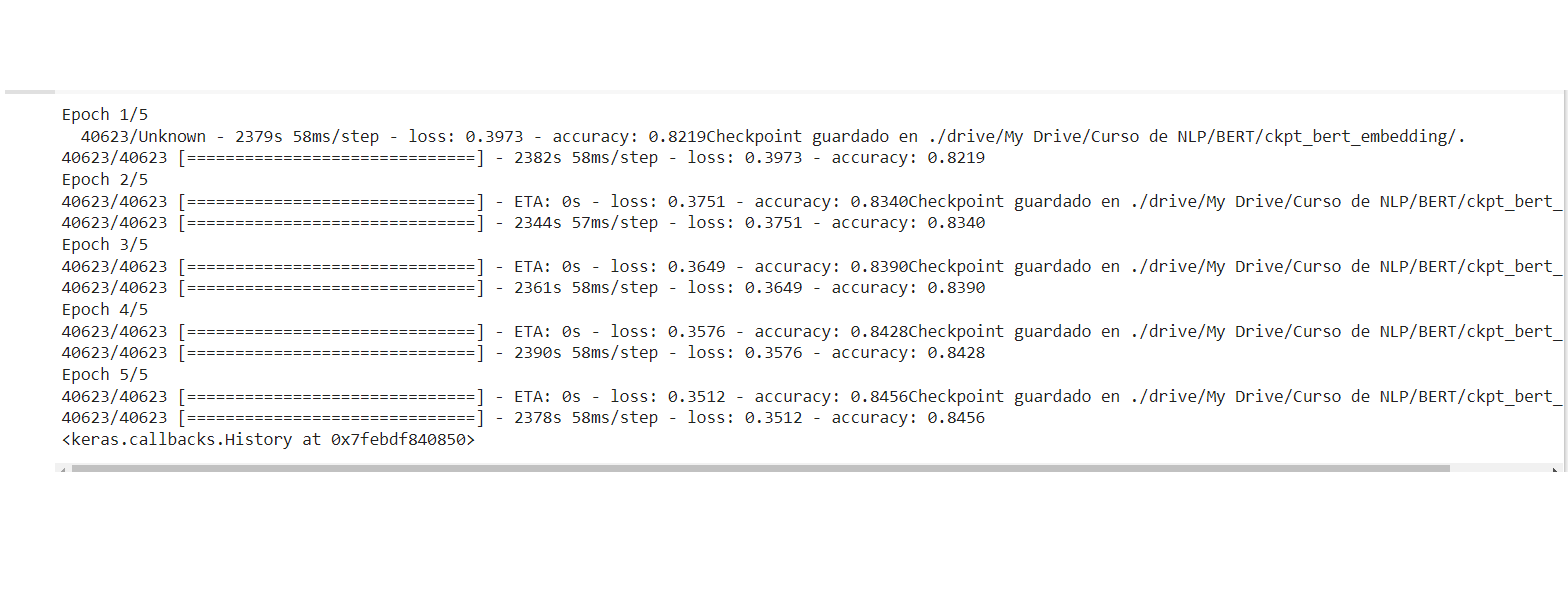

### Opción 2: usar pesos ya entrenados

Como el entrenamiento es largo, casi 20 minutos por epoch, pueden bajar los pesos con este codigo. Y finalmente descomprimir.

Trabajando con las versiones Google Colab Pro tenemos mas recursos y se tarda menos. Cuesta 10U$S al mes.

In [6]:
url = 'https://drive.google.com/uc?id=1DqTPSY_GuPJsZWURojQIbBLj4J8pVenW'
output = 'pesos.zip'
gdown.download(url, output, quiet=False)

!unzip pesos.zip -d /content/


Downloading...
From: https://drive.google.com/uc?id=1DqTPSY_GuPJsZWURojQIbBLj4J8pVenW
To: /content/pesos.zip
100%|██████████| 411M/411M [00:04<00:00, 87.3MB/s]


Archive:  pesos.zip
  inflating: /content/ckpt_bert_embedding/checkpoint  
  inflating: /content/ckpt_bert_embedding/ckpt-5.index  
  inflating: /content/ckpt_bert_embedding/ckpt-5.data-00000-of-00001  


In [45]:
checkpoint_path = "/content/ckpt_bert_embedding/"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Último checkpoint restaurado!!")

Último checkpoint restaurado!!


# Fase 5: Evaluación

In [46]:
results = Dcnn.evaluate(test_dataset)
print(results)

4507/4507 [==============================] - 126s 26ms/step - loss: 0.3340 - accuracy: 0.8569
[0.3339705765247345, 0.8569309115409851]


In [48]:
def get_prediction(sentence):
    tokens = encode_sentence(sentence)

    input_ids = get_ids(tokens)
    input_mask = get_mask(tokens)
    segment_ids = get_segments(tokens)

    inputs = tf.stack(
        [tf.cast(input_ids, dtype=tf.int32),
         tf.cast(input_mask, dtype=tf.int32),
         tf.cast(segment_ids, dtype=tf.int32)],
         axis=0)
    inputs = tf.expand_dims(inputs, 0) # simula un lote

    output = Dcnn(inputs, training=False)

    sentiment = math.floor(output*2)

    if sentiment == 0:
        print("Salida del modelo: {}\nSentimiento predicho: Negativo.".format(
            output))
    elif sentiment == 1:
        print("Salida del modelo: {}\nSentimiento predicho: Positivo.".format(
            output))

In [49]:
get_prediction("This actor is a deception.")#Este actor es un engaño

Salida del modelo: [[0.16945675]]
Sentimiento predicho: Negativo.


In [50]:
get_prediction("It's an engaging movie.")#Es una pelicula atractiva

Salida del modelo: [[0.97524965]]
Sentimiento predicho: Positivo.


In [51]:
get_prediction("It's not an entertaining work")#No es un trabajo entretenido

Salida del modelo: [[0.19939518]]
Sentimiento predicho: Negativo.


In [52]:
get_prediction("Es feliz de terminar la clase")

Salida del modelo: [[0.83152086]]
Sentimiento predicho: Positivo.
